# Разведывательный анализ данных. Оценка влияния условий жизни учащихся на их успеваемость по математике.

Цель — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import functools
import itertools
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

## Вспомогательные функции

In [2]:
def get_nonintegers(ser: pd.Series):
    """Возвращает все уникальные значения, не являющиеся целыми числами"""
    return ser[ser != ser.astype(int, errors='ignore')].unique()

In [3]:
def get_out_bounds(ser: pd.Series):
    """Возвращает границы, снаружи которых находятся выбросы"""
    qu25 = ser.quantile(0.25, interpolation='midpoint')
    qu75 = ser.quantile(0.75, interpolation='midpoint')
    iqr = qu75 - qu25
    return qu25 - 1.5 * iqr, qu75 + 1.5 * iqr

In [4]:
def int_hist(ser: pd.Series):
    """Строит гистограмму из последовательности целых чисел с интервалом для каждого числа"""
    ser.hist(bins=np.arange(ser.min() - 0.5, ser.max() + 1.5))

## Загрузка исходного датасета

Исходный csv, похоже, в стандартном формате.

In [5]:
sm = pd.read_csv('stud_math.csv')

In [6]:
sm.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

Приведём названия к питоничному виду.

In [7]:
sm.rename(
    columns={
        'studytime, granular': 'studytime_gr',
        'Pstatus': 'p_status',
        'Medu': 'm_edu',
        'Fedu': 'f_edu',
        'Mjob': 'm_job',
        'Fjob': 'f_job',
    }, 
    inplace=True
)

In [8]:
sm

,school,sex,age,address,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_gr,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


Похоже, что загрузилось адекватно.

## Первый взгляд на данные по столбцам и предварительная обработка

In [9]:
feature_kind = {}
# для хранения свойств признака. Значения:
# 'cat' - категориальный 
# 'num' - числовой

In [10]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   school        395 non-null    object 
 1   sex           395 non-null    object 
 2   age           395 non-null    int64  
 3   address       378 non-null    object 
 4   famsize       368 non-null    object 
 5   p_status      350 non-null    object 
 6   m_edu         392 non-null    float64
 7   f_edu         371 non-null    float64
 8   m_job         376 non-null    object 
 9   f_job         359 non-null    object 
 10  reason        378 non-null    object 
 11  guardian      364 non-null    object 
 12  traveltime    367 non-null    float64
 13  studytime     388 non-null    float64
 14  failures      373 non-null    float64
 15  schoolsup     386 non-null    object 
 16  famsup        356 non-null    object 
 17  paid          355 non-null    object 
 18  activities    381 non-null    

### school
_аббревиатура школы, в которой учится ученик._

Пропусков нет. Должен содержать строки.

In [11]:
sm.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

Тип правильный. Корректность значений не известна.

In [12]:
feature_kind['school'] = 'cat'

### sex
_пол ученика ('F' - женский, 'M' - мужской)_

Пропусков нет. Должен содержать строки из заданного набора.

In [13]:
sm.sex.value_counts()

F    208
M    187
Name: sex, dtype: int64

Значения из корректного набора.

In [14]:
feature_kind['sex'] = 'cat'

### age
_возраст ученика (от 15 до 22)_


Целочисленный, без пропусков.

In [15]:
sm.age.describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

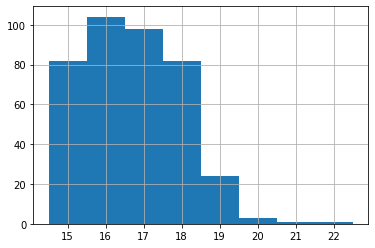

In [16]:
int_hist(sm.age)

Значения в корректном диапазоне.

In [17]:
get_out_bounds(sm.age)

(13.0, 21.0)

Есть статистические выбросы. Допустим, наша модель требует отсутствия выбросов в числовых признаках обучающей выборки. Заменим все, старше 20, на 20.

In [18]:
sm.age.mask(sm.age > 20, 20, inplace=True)

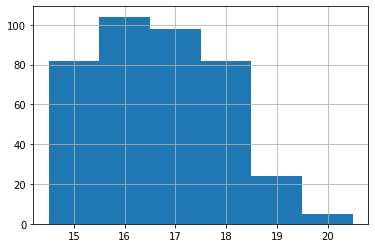

In [19]:
int_hist(sm.age)

In [20]:
feature_kind['age'] = 'num'

### address
_тип адреса ученика ('U' - городской, 'R' - за городом)_

Есть пропуски. Должен содержать строки из заданного набора.

In [21]:
sm.address.value_counts(dropna=False)

U      295
R       83
NaN     17
Name: address, dtype: int64

Непропущенные значения из корректного набора.

In [22]:
feature_kind['address'] = 'cat'

### famsize
_размер семьи('LE3' <= 3, 'GT3' >3)_

Есть пропуски. Должен содержать строки из заданного набора.

In [23]:
sm.famsize.value_counts(dropna=False)

GT3    261
LE3    107
NaN     27
Name: famsize, dtype: int64

Непропущенные значения из корректного набора.

In [24]:
feature_kind['famsize'] = 'cat'

### p_status
_статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)_

Есть пропуски. Должен содержать строки из заданного набора.

In [25]:
sm.p_status.value_counts(dropna=False)

T      314
NaN     45
A       36
Name: p_status, dtype: int64

Непропущенные значения из корректного набора.

In [26]:
feature_kind['p_status'] = 'cat'

### m_edu
_образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [27]:
sm.m_edu.value_counts(dropna=False)

4.0    131
2.0    102
3.0     97
1.0     59
NaN      3
0.0      3
Name: m_edu, dtype: int64

Непропущенные значения из корректного набора.

In [28]:
feature_kind['m_edu'] = 'cat'

### f_edu
_образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [29]:
sm.f_edu.value_counts(dropna=False)

2.0     106
3.0      96
4.0      88
1.0      78
NaN      24
0.0       2
40.0      1
Name: f_edu, dtype: int64

Есть некорректное значение. Пока что заменяем его на пропуск.

In [30]:
sm.f_edu.mask(~sm.f_edu.between(0, 4), None, inplace=True)

In [31]:
feature_kind['f_edu'] = 'cat'

### m_job
_работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)_

Есть пропуски. Должен содержать строки из заданного набора.

In [32]:
sm.m_job.value_counts(dropna=False)

other       133
services     98
at_home      58
teacher      55
health       32
NaN          19
Name: m_job, dtype: int64

Непропущенные значения из корректного набора.

In [33]:
feature_kind['m_job'] = 'cat'

### f_job
_работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)_

Есть пропуски. Должен содержать строки из заданного набора.

In [34]:
sm.f_job.value_counts(dropna=False)

other       197
services    102
NaN          36
teacher      29
at_home      16
health       15
Name: f_job, dtype: int64

Непропущенные значения из корректного набора.

In [35]:
feature_kind['f_job'] = 'cat'

### reason
_причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)_

Есть пропуски. Должен содержать строки из заданного набора.

In [36]:
sm.reason.value_counts(dropna=False)

course        137
home          104
reputation    103
other          34
NaN            17
Name: reason, dtype: int64

Непропущенные значения из корректного набора.

In [37]:
feature_kind['reason'] = 'cat'

### guardian
_опекун ('mother' - мать, 'father' - отец, 'other' - другое)_

Есть пропуски. Должен содержать строки из заданного набора.

In [38]:
sm.guardian.value_counts(dropna=False)

mother    250
father     86
NaN        31
other      28
Name: guardian, dtype: int64

Непропущенные значения из корректного набора.

In [39]:
feature_kind['guardian'] = 'cat'

### traveltime
_время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [40]:
sm.traveltime.value_counts(dropna=False)

1.0    242
2.0     96
NaN     28
3.0     22
4.0      7
Name: traveltime, dtype: int64

Непропущенные значения из корректного набора.

In [41]:
feature_kind['traveltime'] = 'cat'

### studytime
_время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [42]:
sm.studytime.value_counts(dropna=False)

2.0    194
1.0    103
3.0     64
4.0     27
NaN      7
Name: studytime, dtype: int64

Непропущенные значения из корректного набора.

In [43]:
feature_kind['studytime'] = 'cat'

### failures
_количество внеучебных неудач(?) (n, если 1<=n<=3, иначе 0)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [44]:
sm.failures.value_counts(dropna=False)

0.0    293
1.0     49
NaN     22
2.0     16
3.0     15
Name: failures, dtype: int64

In [45]:
feature_kind['failures'] = 'cat'

### schoolsup
_дополнительная образовательная поддержка (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [46]:
sm.schoolsup.value_counts(dropna=False)

no     335
yes     51
NaN      9
Name: schoolsup, dtype: int64

Непропущенные значения из корректного набора.

In [47]:
feature_kind['schoolsup'] = 'cat'

### famsup
_семейная образовательная поддержка (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [48]:
sm.famsup.value_counts(dropna=False)

yes    219
no     137
NaN     39
Name: famsup, dtype: int64

Непропущенные значения из корректного набора.

In [49]:
feature_kind['famsup'] = 'cat'

### paid
_дополнительные платные занятия по математике (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [50]:
sm.paid.value_counts(dropna=False)

no     200
yes    155
NaN     40
Name: paid, dtype: int64

Непропущенные значения из корректного набора.

In [51]:
feature_kind['paid'] = 'cat'

### activities
_дополнительные внеучебные занятия (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [52]:
sm.activities.value_counts(dropna=False)

yes    195
no     186
NaN     14
Name: activities, dtype: int64

Непропущенные значения из корректного набора.

In [53]:
feature_kind['activities'] = 'cat'

### nursery
_посещал детский сад (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [54]:
sm.nursery.value_counts(dropna=False)

yes    300
no      79
NaN     16
Name: nursery, dtype: int64

Непропущенные значения из корректного набора.

In [55]:
feature_kind['nursery'] = 'cat'

### studytime_gr
Недокументированно.

In [56]:
sm.studytime_gr.value_counts(dropna=False)

-6.0     194
-3.0     103
-9.0      64
-12.0     27
 NaN       7
Name: studytime_gr, dtype: int64

Подозрительно похоже на studytime.

In [57]:
sm.studytime_gr.corr(sm.studytime)

-0.9999999999999991

Линейная зависимость. Сразу удаляем.

In [58]:
sm.drop('studytime_gr', axis=1, inplace=True)

### higher
_хочет получить высшее образование (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [59]:
sm.higher.value_counts(dropna=False)

yes    356
NaN     20
no      19
Name: higher, dtype: int64

Непропущенные значения из корректного набора.

In [60]:
feature_kind['higher'] = 'cat'

### internet
_наличие интернета дома (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [61]:
sm.internet.value_counts(dropna=False)

yes    305
no      56
NaN     34
Name: internet, dtype: int64

Непропущенные значения из корректного набора.

In [62]:
feature_kind['internet'] = 'cat'

### romantic
_в романтических отношениях (yes или no)_

Есть пропуски. Должен содержать строки из заданного набора.

In [63]:
sm.romantic.value_counts(dropna=False)

no     240
yes    124
NaN     31
Name: romantic, dtype: int64

Непропущенные значения из корректного набора.

In [64]:
feature_kind['romantic'] = 'cat'

### famrel
_семейные отношения (от 1 - очень плохо до 5 - очень хорошо)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [65]:
sm.famrel.value_counts(dropna=False)

 4.0    182
 5.0     99
 3.0     62
 NaN     27
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

Есть некорректное значение. Пока что заменяем его на пропуск.

In [66]:
sm.famrel.mask(~sm.famrel.between(1, 5), None, inplace=True)

In [67]:
sm.famrel.value_counts(dropna=False)

4.0    182
5.0     99
3.0     62
NaN     28
2.0     17
1.0      7
Name: famrel, dtype: int64

In [68]:
feature_kind['famrel'] = 'cat'

### freetime
_свободное время после школы (от 1 - очень мало до 5 - очень много)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [69]:
sm.freetime.value_counts(dropna=False)

3.0    153
4.0    112
2.0     63
5.0     38
1.0     18
NaN     11
Name: freetime, dtype: int64

Непропущенные значения из корректного набора.

In [70]:
feature_kind['freetime'] = 'cat'

### goout
_проведение времени с друзьями (от 1 - очень мало до 5 - очень много)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [71]:
sm.goout.value_counts(dropna=False)

3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
NaN      8
Name: goout, dtype: int64

Непропущенные значения из корректного набора.

In [72]:
feature_kind['goout'] = 'cat'

### health
_текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)_

Числовой с пропусками. Должен содержать целые числа из заданного набора.

In [73]:
sm.health.value_counts(dropna=False)

5.0    138
3.0     89
4.0     63
1.0     47
2.0     43
NaN     15
Name: health, dtype: int64

Непропущенные значения из корректного набора.

In [74]:
feature_kind['health'] = 'cat'

### absences
_количество пропущенных занятий_

Числовой с пропусками. Должен содержать неотрицательные целые числа.

In [75]:
get_nonintegers(sm.absences)

array([nan])

Все числа целые.

In [76]:
sm.absences.describe()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

<AxesSubplot:>

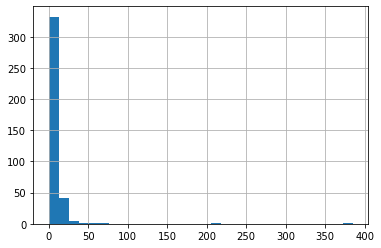

In [77]:
sm.absences.hist(bins=30)

In [78]:
get_out_bounds(sm.absences)

(-12.0, 20.0)

Отрицательных нет. Есть сильно отклонившиеся выбросы. Заменим их на верхний квартиль плюс полтора межквартильных размаха.

In [79]:
highest = round(get_out_bounds(sm.absences)[1])
highest

20

In [80]:
sm.absences.mask(sm.absences > highest, highest, inplace=True)

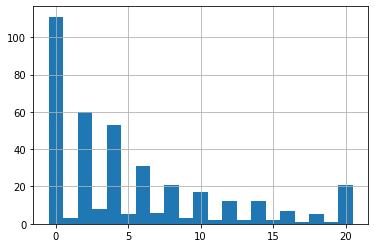

In [81]:
int_hist(sm.absences)

Похоже, занятия сгруппированы по парам.

In [82]:
feature_kind['absences'] = 'num'

### score
_баллы по госэкзамену по математике_

Целевая переменная.

In [83]:
target = 'score'

Числовой с пропусками. Скорее всего, должен содержать неотрицательные целые числа, ограниченные сверху круглым числом.

In [84]:
get_nonintegers(sm.score)

array([nan])

In [85]:
sm.score.describe()

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

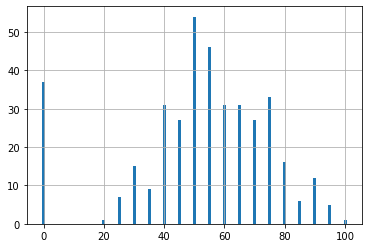

In [86]:
int_hist(sm.score)

Неизвестно, является ли 0 валидным баллом или отсутствием данных. Судя по распределению — скорее второе.

Поскольку столбец содержит целевую переменную, удаляем из датасета все строки, в которых он не заполнен.

In [87]:
sm = sm[sm.score > 0]

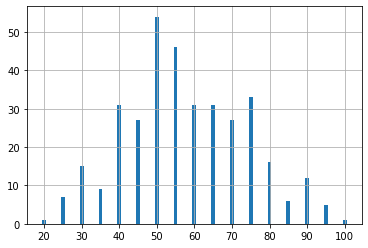

In [88]:
int_hist(sm.score)

In [89]:
get_out_bounds(sm.score)

(7.5, 107.5)

Выглядит нормально. Выбросов нет.

In [90]:
assert not sm.columns.symmetric_difference(list(feature_kind.keys()) + [target]).size

## Выделение значимых данных

Определим столбцы, значимые для обучения. Целевая переменная к ним, естественно, относится.

In [91]:
relevant_columns = {target}

Рассмотрим числовые признаки.

In [92]:
num_features = [
    column_name 
    for column_name, kind in feature_kind.items()
    if column_name in sm.columns and kind == 'num'
]
', '.join(num_features)

'age, absences'

Их корреляция между собой и целевой переменной

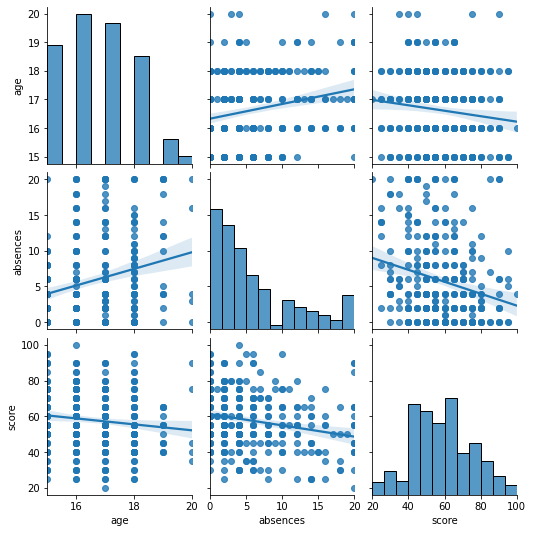

In [93]:
sns.pairplot(sm[num_features + [target]], kind='reg')

In [94]:
sm[num_features + [target]].corr()

,age,absences,score
age,1.000000,0.245044,-0.126294
absences,0.245044,1.000000,-0.230017
score,-0.126294,-0.230017,1.000000


Признаки коррелируют между собой не настолько сильно, чтобы исключать какой-то из них, и достаточно коррелируют с целевой переменной. Будем считать оба значимыми.

In [95]:
relevant_columns.update(num_features)

Рассмотрим категориальные признаки.

In [96]:
cat_features = [
    column_name 
    for column_name, kind in feature_kind.items()
    if column_name in sm.columns and kind == 'cat'
]
', '.join(cat_features)

'school, sex, address, famsize, p_status, m_edu, f_edu, m_job, f_job, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, health'

Определим значимые с помощью теста Стьюдента.

In [97]:
relevant_cat_features = []

for column_name in cat_features:
    vals = sm[column_name].dropna().unique()
    vals_combinations = list(itertools.combinations(vals, 2))
    for val1, val2 in vals_combinations:
        if st.ttest_ind(
            sm[target][sm[column_name] == val1],
            sm[target][sm[column_name] == val2],
        ).pvalue < 0.05 / len(vals_combinations):
            relevant_cat_features.append(column_name)
            break
    
', '.join(relevant_cat_features)

'address, m_edu, f_edu, m_job, f_job, studytime, failures, schoolsup, goout'

In [98]:
relevant_columns.update(relevant_cat_features)

Посмотрим на их отношения с целевой переменной.

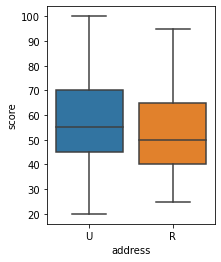

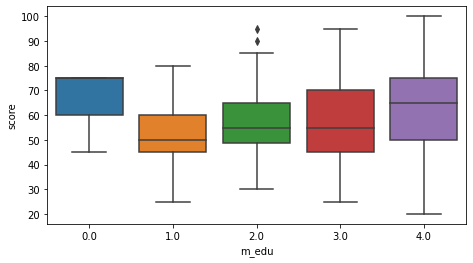

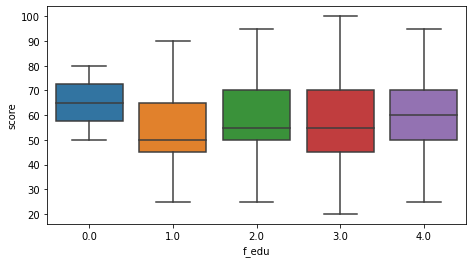

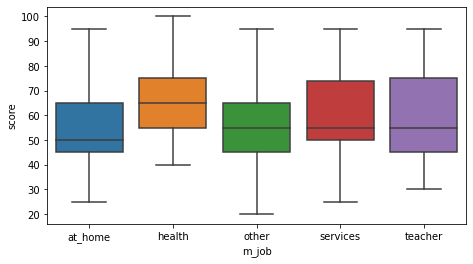

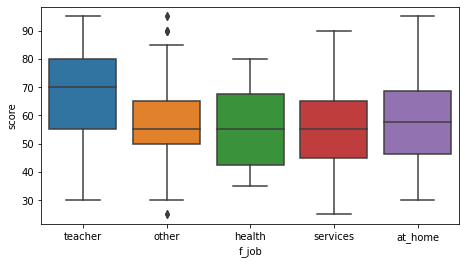

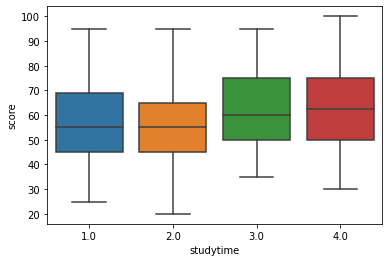

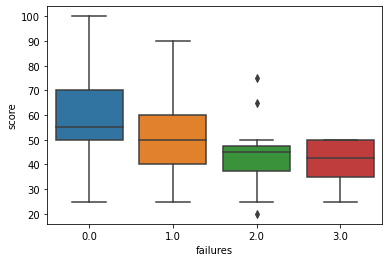

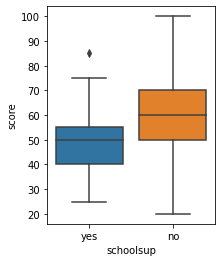

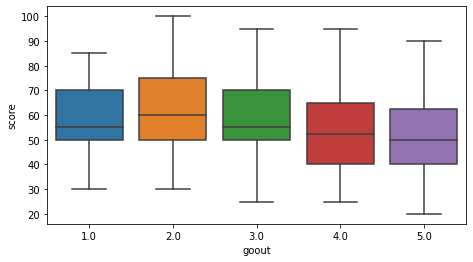

In [99]:
for column_name in relevant_cat_features:
    fig, ax = plt.subplots(
        figsize=(
            1.5 * sm[column_name].dropna().unique().size,
            4
        )
    )
    sns.boxplot(x=column_name, y=target, data=sm, ax=ax)

Видны зависимости.

Видно наличие некоторого количества выбросов, возможно, стоит обратить на них более подробное внимание.

Возможно, стоит рассмотреть упорядоченные категориальные признаки (заданные числами) и категориальные признаки с двумя значениями в качестве числовых.

Оставим в датасете только значимые столбцы.

In [100]:
sm = sm[relevant_columns]

Допустим, наша модель требует отсутствия пропусков в обучающих данных. Попробуем просто оставить только строки, не содержащие пропуски.

In [101]:
complete_rows = functools.reduce(
    lambda a, b: a & b, 
    (col.notna() for _, col in sm.iteritems())
)
complete_rows.sum()

236

Останется достаточное количество данных. Оставляем только полные строки.

In [102]:
sm = sm[complete_rows]

Итоговый датасет

In [103]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 0 to 393
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   address    236 non-null    object 
 1   studytime  236 non-null    float64
 2   failures   236 non-null    float64
 3   absences   236 non-null    float64
 4   m_edu      236 non-null    float64
 5   schoolsup  236 non-null    object 
 6   score      236 non-null    float64
 7   f_job      236 non-null    object 
 8   goout      236 non-null    float64
 9   m_job      236 non-null    object 
 10  age        236 non-null    int64  
 11  f_edu      236 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 24.0+ KB


## Выводы

* В данных довольно много пропусков. Нельзя сказать, что пропуски сосредоточены в какой-то части датасета. В значимых столбцах нашлось достаточное количество общих записей без пропусков.
* В данных небольшое количество ошибок, за исключением нулевых score. Скорее всего, подавляющая часть статистических выбросов являются фактически верными значениями, а не ошибками.
* Для построения модели предлагается использовать следующие столбцы: absences, address, age, f_edu, f_job, failures, goout, m_edu, m_job, schoolsup, studytime, score.